First cluster


In [1]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload 2
from model import *
from load_data import *
from utils import *

99.9% of data retained after cleaning


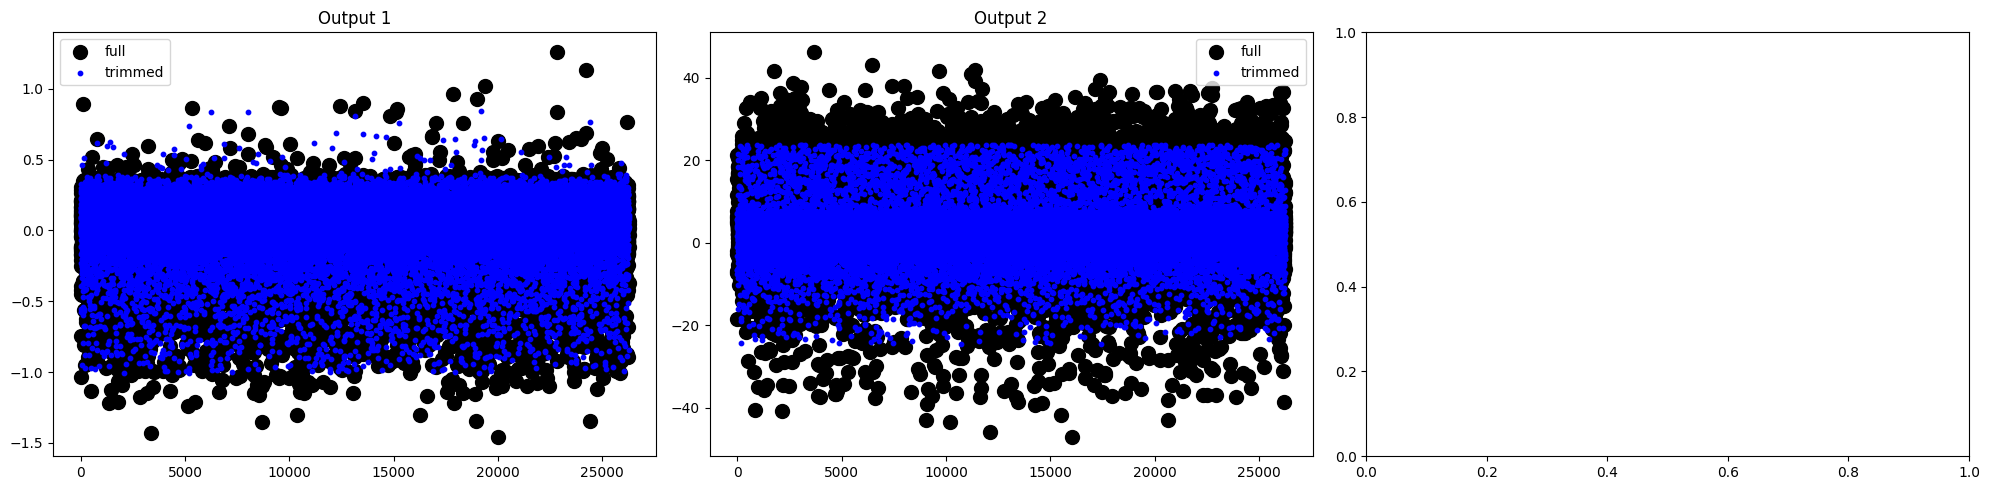

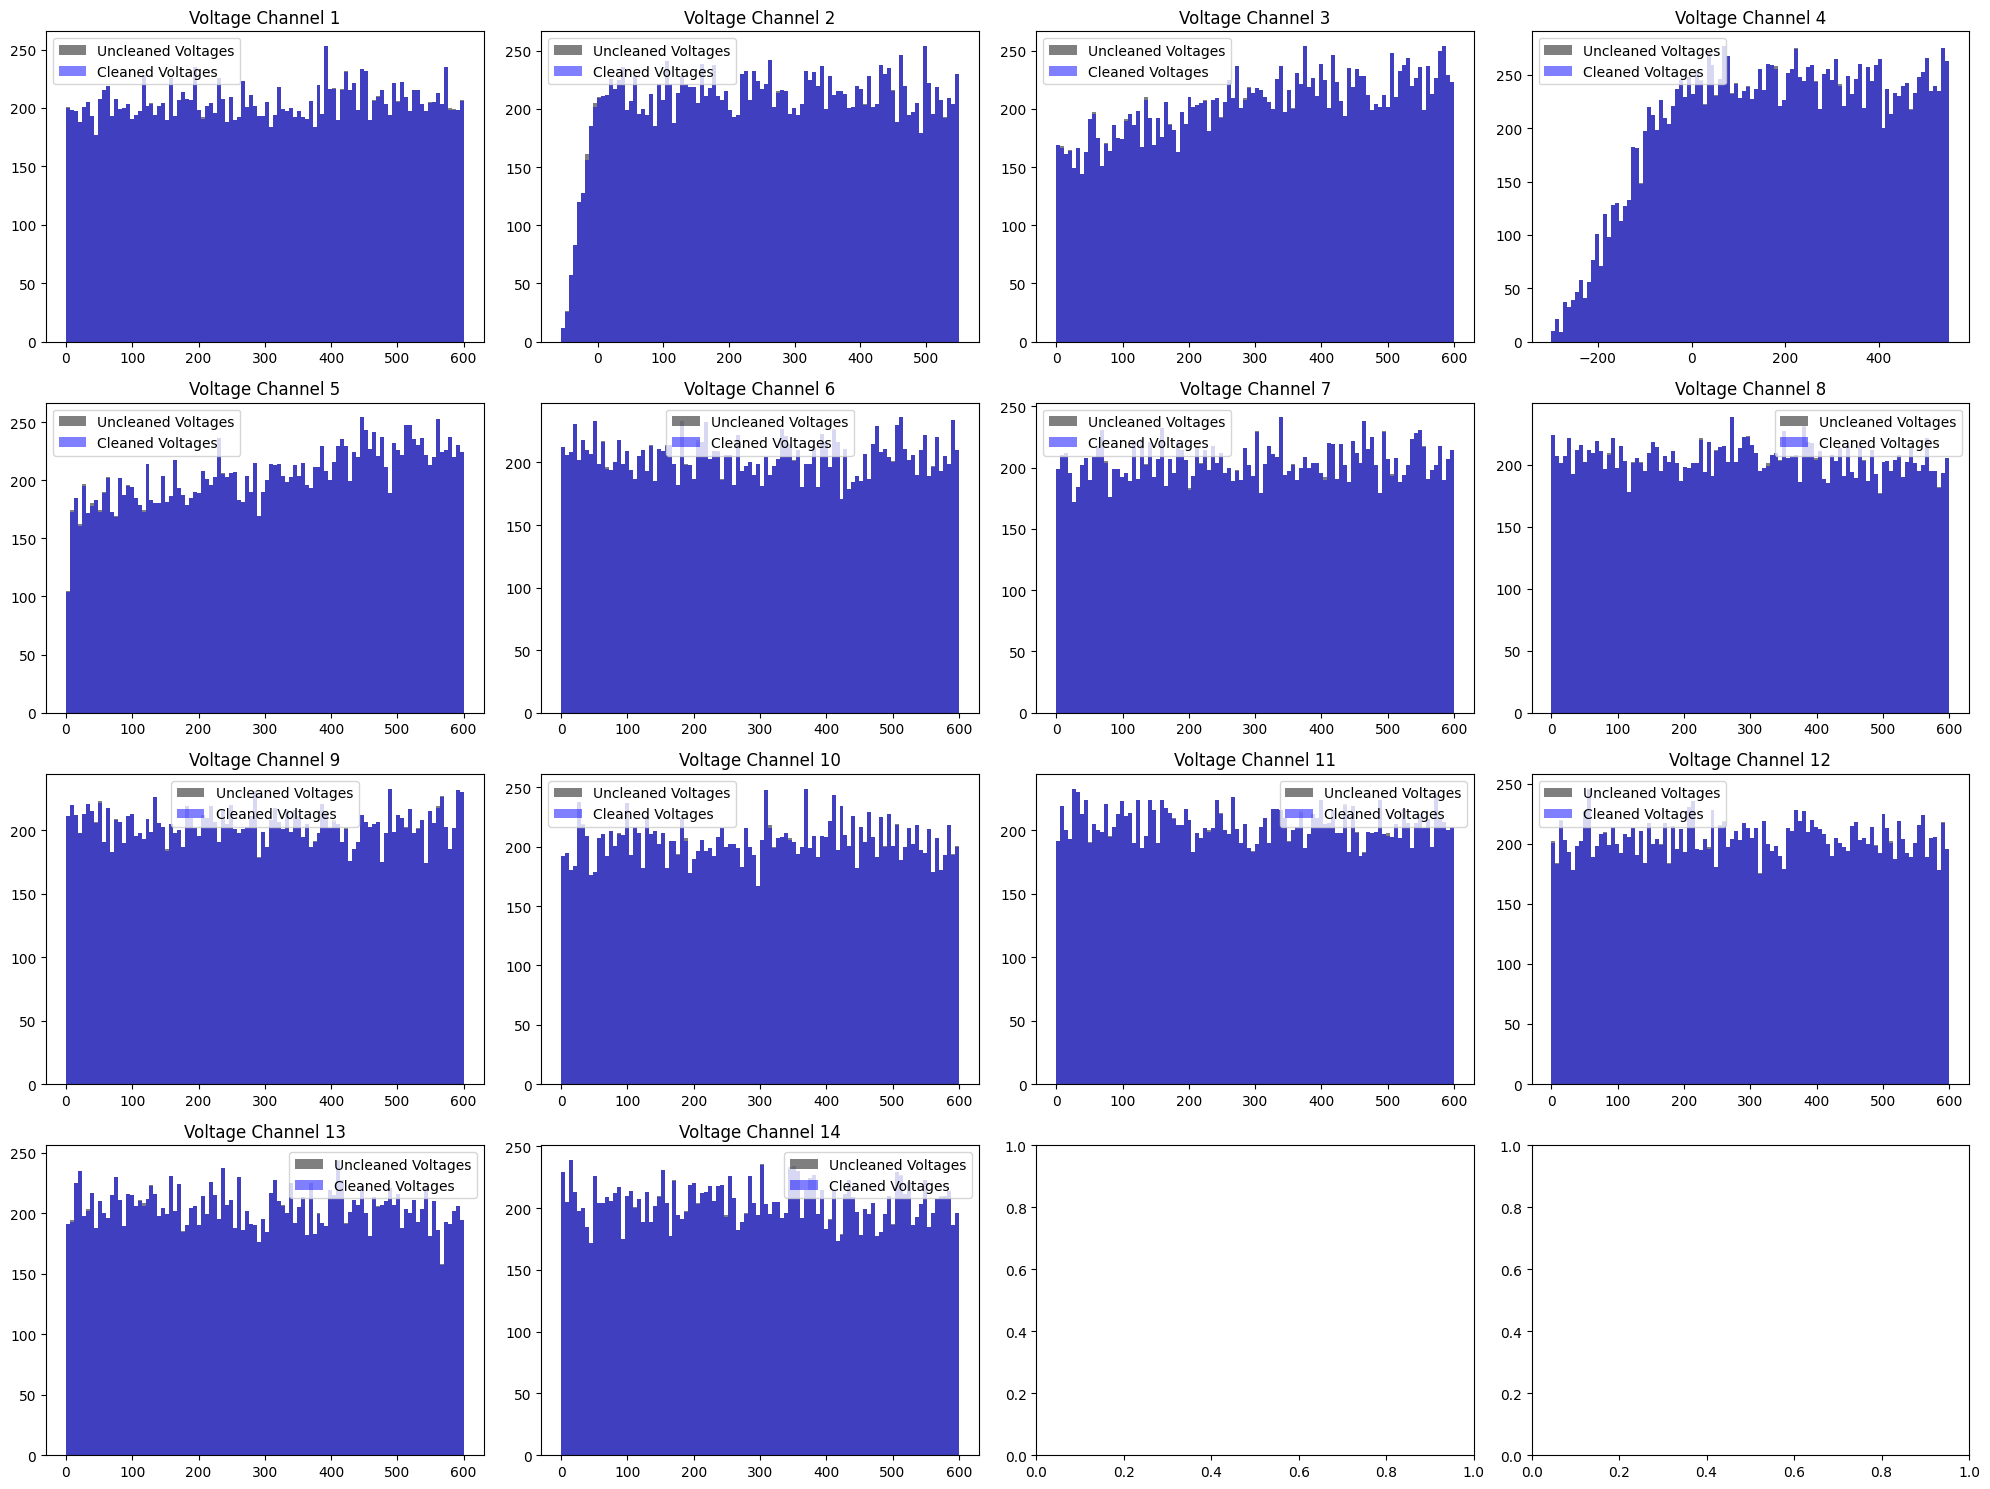

In [3]:
threshold = 4
trim_mode = "iqr"
_, ax, _, _, _, _ = trim_scatter(
    [
        "test_model_data.csv",
        "parallel_test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=14,
    output_values_end=15,
    trim_mode=trim_mode,
    trim_threshold=threshold,
    subplot_shape=(1, 3),
    figsize=(20, 5),
)
# ax[0].set_xlim(0, 100)
# ax[0].set_ylim(-5, 5)
_, _, _, _, fig, ax = trim_hist(
    [
        "test_model_data.csv",
        "parallel_test_model_data.csv",
        # "outlier_target_model_data.csv",
    ],
    output_values_start=14,
    output_values_end=15,
    trim_mode=trim_mode,
    trim_threshold=threshold,
    subplot_shape=(4, 4),
)

Using device: cpu
Training model...
Epoch 0: Train Loss = 0.639851, Val Loss = 0.300157
Epoch 100: Train Loss = 0.042060, Val Loss = 0.035760
Epoch 200: Train Loss = 0.039089, Val Loss = 0.034997
Epoch 300: Train Loss = 0.036787, Val Loss = 0.034061
Epoch 400: Train Loss = 0.030475, Val Loss = 0.033200
Epoch 500: Train Loss = 0.029080, Val Loss = 0.027034
Epoch 600: Train Loss = 0.024074, Val Loss = 0.023118
Epoch 700: Train Loss = 0.020345, Val Loss = 0.020225
Epoch 800: Train Loss = 0.016741, Val Loss = 0.015788
Epoch 900: Train Loss = 0.013314, Val Loss = 0.021193
Training completed. Best validation loss: 0.013398


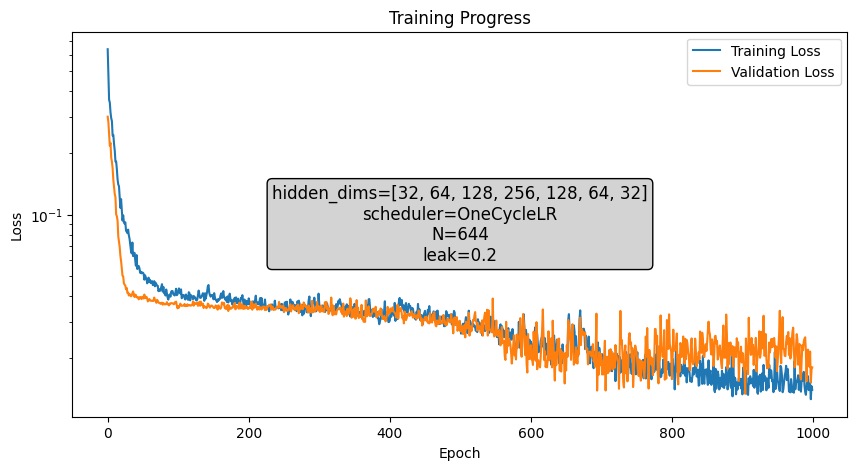

In [4]:
n_voltages = 14  # Number of voltage parameters
n_output_values = 2  # Number of output values (e.g., magnification, aberration, etc.)
raw_voltages, raw_outputs = load_data(
    [
        "parallel_test_model_data.csv",
        "test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=14,
    output_values_end=15,
)
voltages, outputs, outlier_voltages, outlier_outputs = trim_outliers(
    raw_voltages,
    raw_outputs,
    trim_threshold=threshold,
    trim_mode=trim_mode,
)
# Create and train model
predictor1 = ElectronOpticsPredictor(
    input_dim=n_voltages, output_dim=n_output_values, leak=0.2
)
print("Training model...")
predictor1.train(
    outlier_voltages,
    outlier_outputs,
    epochs=1000,
    verbose=True,
    weight_name="best_model1.pth",
)
predictor1.save_model("outlier_predictor1")

In [21]:
solid_angle_scaling = math.sin(math.radians(5 / 2)) / math.sin(math.radians(60 / 2))
APER_0_D = 0.5
DET_D = 25


def angle_resolved_aper0(aper0_map: torch.Tensor) -> torch.Tensor:
    aberrations = (
        aper0_map[0] ** 2
        + aper0_map[2] ** 2
        + (aper0_map[3] * solid_angle_scaling) ** 2
        + (aper0_map[4] * (solid_angle_scaling**2)) ** 2
        + (aper0_map[5] * (solid_angle_scaling**3)) ** 2
    )
    return (
        aberrations
        + (torch.abs(aper0_map[1] * solid_angle_scaling) - APER_0_D / 2) ** 2
    )


def spatial_resolved_detector(detector_map: torch.Tensor) -> torch.Tensor:
    aberrations = (
        (detector_map[1] * solid_angle_scaling) ** 2
        + detector_map[2] ** 2
        + (detector_map[3] * solid_angle_scaling) ** 2
        + (detector_map[4] * (solid_angle_scaling**2)) ** 2
        + (detector_map[5] * (solid_angle_scaling**3)) ** 2
    )
    return aberrations + (torch.abs(detector_map[0]) - DET_D / 2) ** 2


def metric(output: torch.Tensor | np.ndarray):
    if isinstance(output, np.ndarray):
        if output.ndim == 1:
            output = torch.tensor(output)
        else:
            all_metrics = []
            for single_output in output:
                all_metrics.append(metric(single_output))
            return all_metrics
    return angle_resolved_aper0(output[:6]) * 1000 + spatial_resolved_detector(
        output[6:]
    )


metric(raw_outputs)

IndexError: index 2 is out of bounds for dimension 0 with size 2

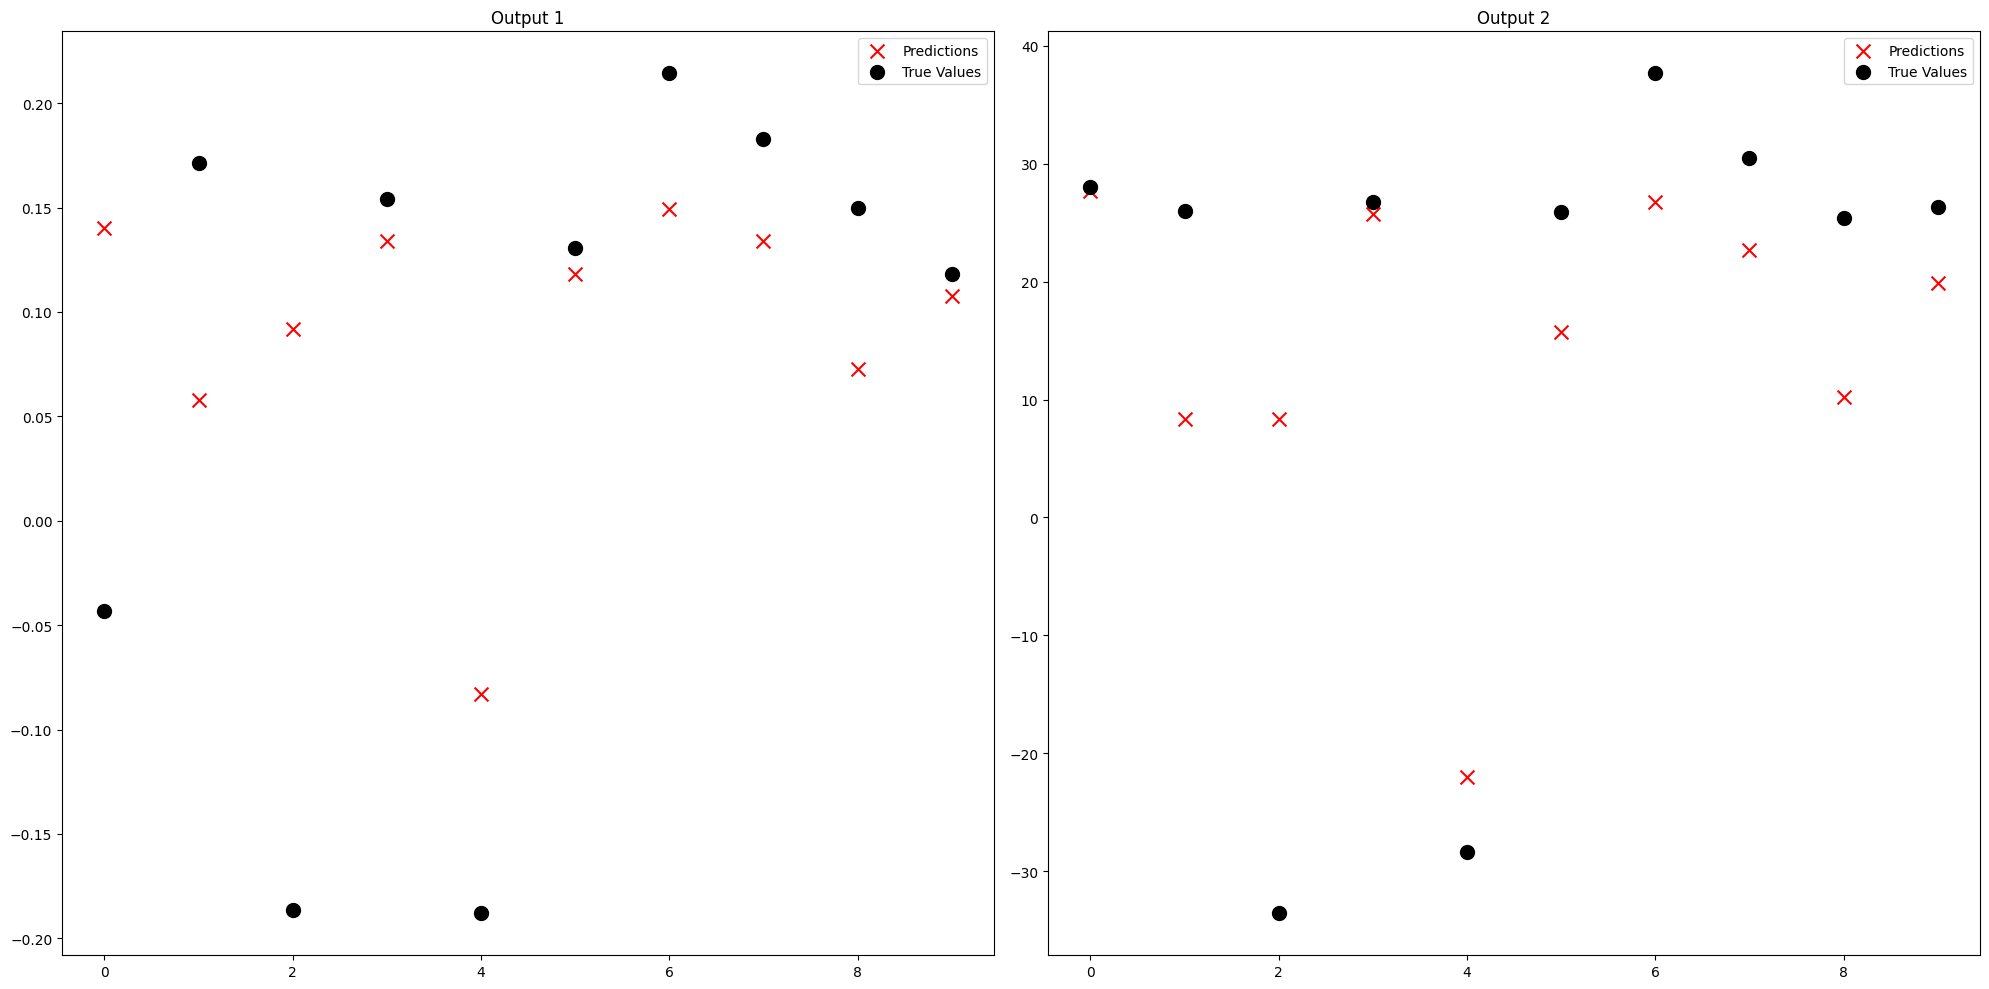

In [5]:
_, _, all_predictions, all_true_values = plot_inference_comparison(
    predictor1, n_samples=10, subplot_shape=(1, 2)
)

cluster 2

79.3% of data retained after cleaning


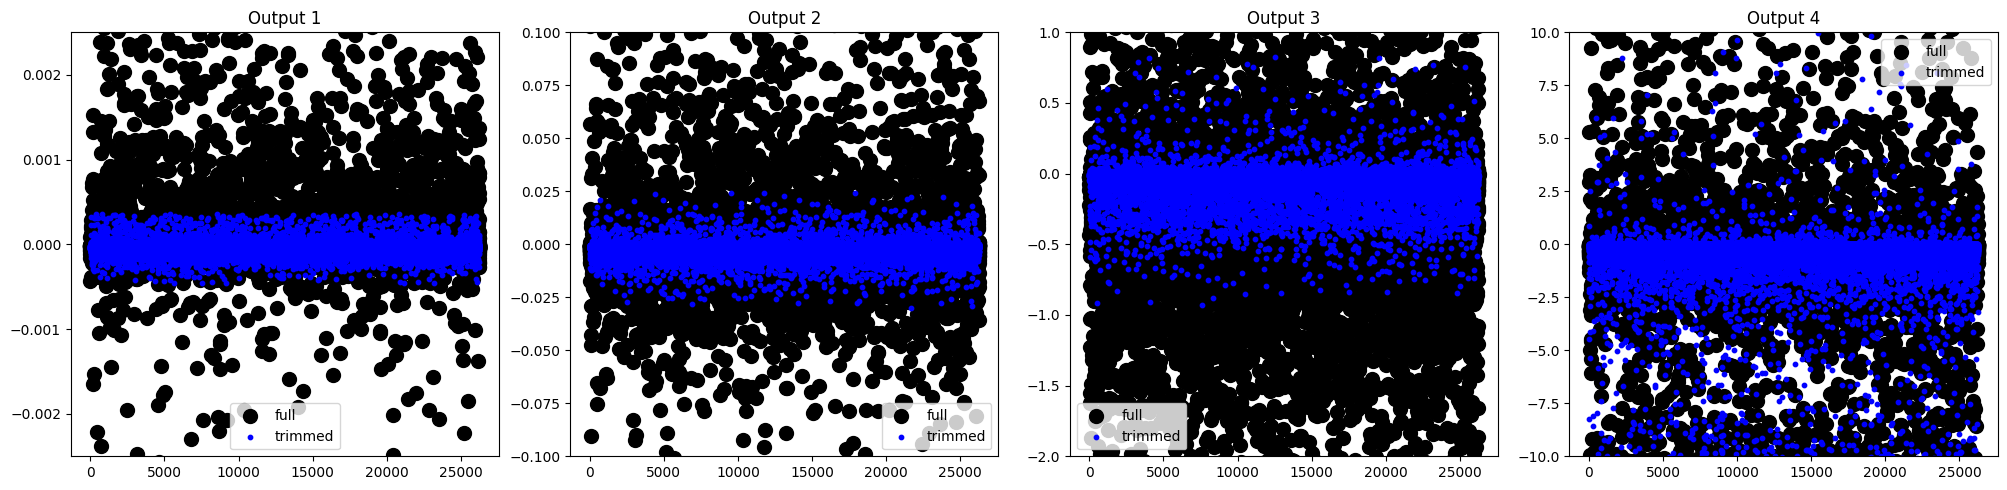

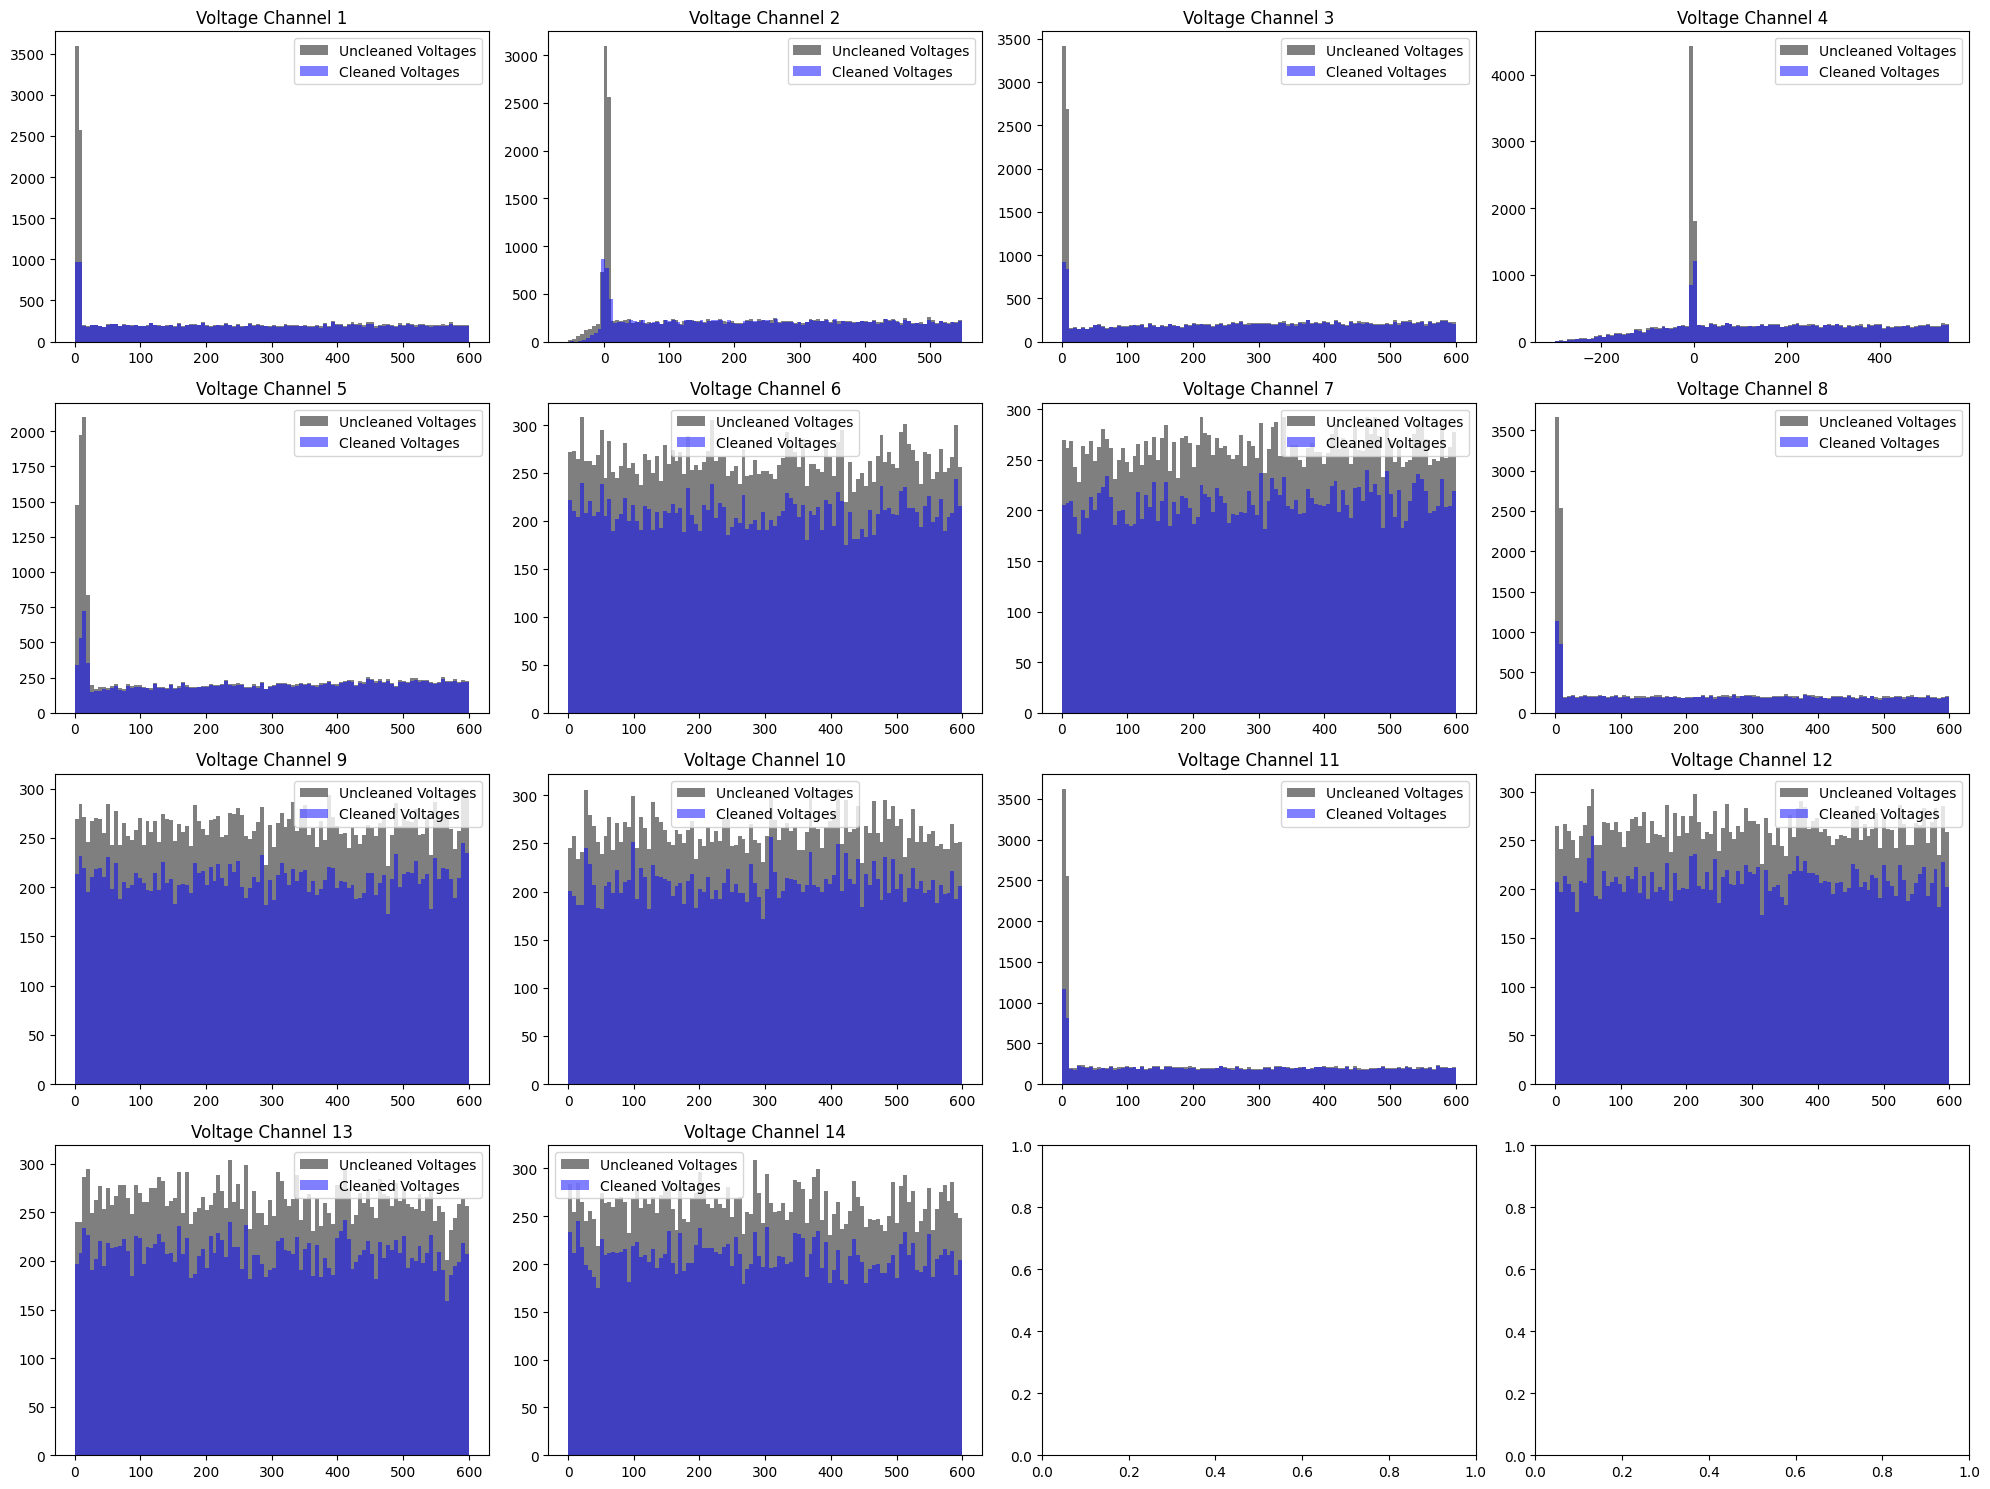

In [6]:
threshold = [10, 10, 10, 10]  # Thresholds for each output value
trim_mode = "iqr"
_, ax, _, _, _, _ = trim_scatter(
    [
        "test_model_data.csv",
        "parallel_test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=16,
    output_values_end=19,
    trim_threshold=threshold,
    trim_mode=trim_mode,
    subplot_shape=(1, 4),
    figsize=(20, 5),
)
# ax[0].set_xlim(0, 100)

ax[0].set_ylim(-0.0025, 0.0025)
ax[1].set_ylim(-0.1, 0.1)
ax[2].set_ylim(-2, 1)
ax[3].set_ylim(-10, 10)

_, _, _, _, fig, ax = trim_hist(
    [
        "test_model_data.csv",
        "parallel_test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=16,
    output_values_end=19,
    trim_threshold=threshold,
    trim_mode=trim_mode,
    subplot_shape=(4, 4),
)

Using device: cpu
Training model...
Epoch 0: Train Loss = 0.711081, Val Loss = 0.440416
Training completed. Best validation loss: 0.000371


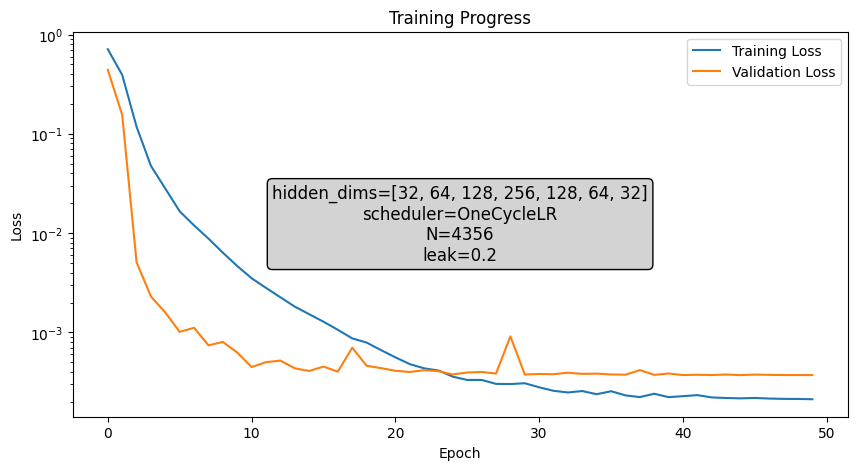

In [7]:
n_voltages = 14  # Number of voltage parameters
n_output_values = 4  # Number of output values (e.g., magnification, aberration, etc.)
raw_voltages, raw_output_values = load_data(
    [
        "parallel_test_model_data.csv",
        "test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=16,
    output_values_end=19,
)
voltages, outputs, outlier_voltages, outlier_outputs = trim_outliers(
    raw_voltages,
    raw_output_values,
    trim_threshold=threshold,
    trim_mode=trim_mode,
)
# Create and train model
predictor2 = ElectronOpticsPredictor(
    input_dim=n_voltages, output_dim=n_output_values, leak=0.2
)
print("Training model...")
predictor2.train(
    outlier_voltages,
    outlier_outputs,
    epochs=50,
    verbose=True,
    weight_name="best_model2.pth",
)
predictor2.save_model("outlier_predictor2")

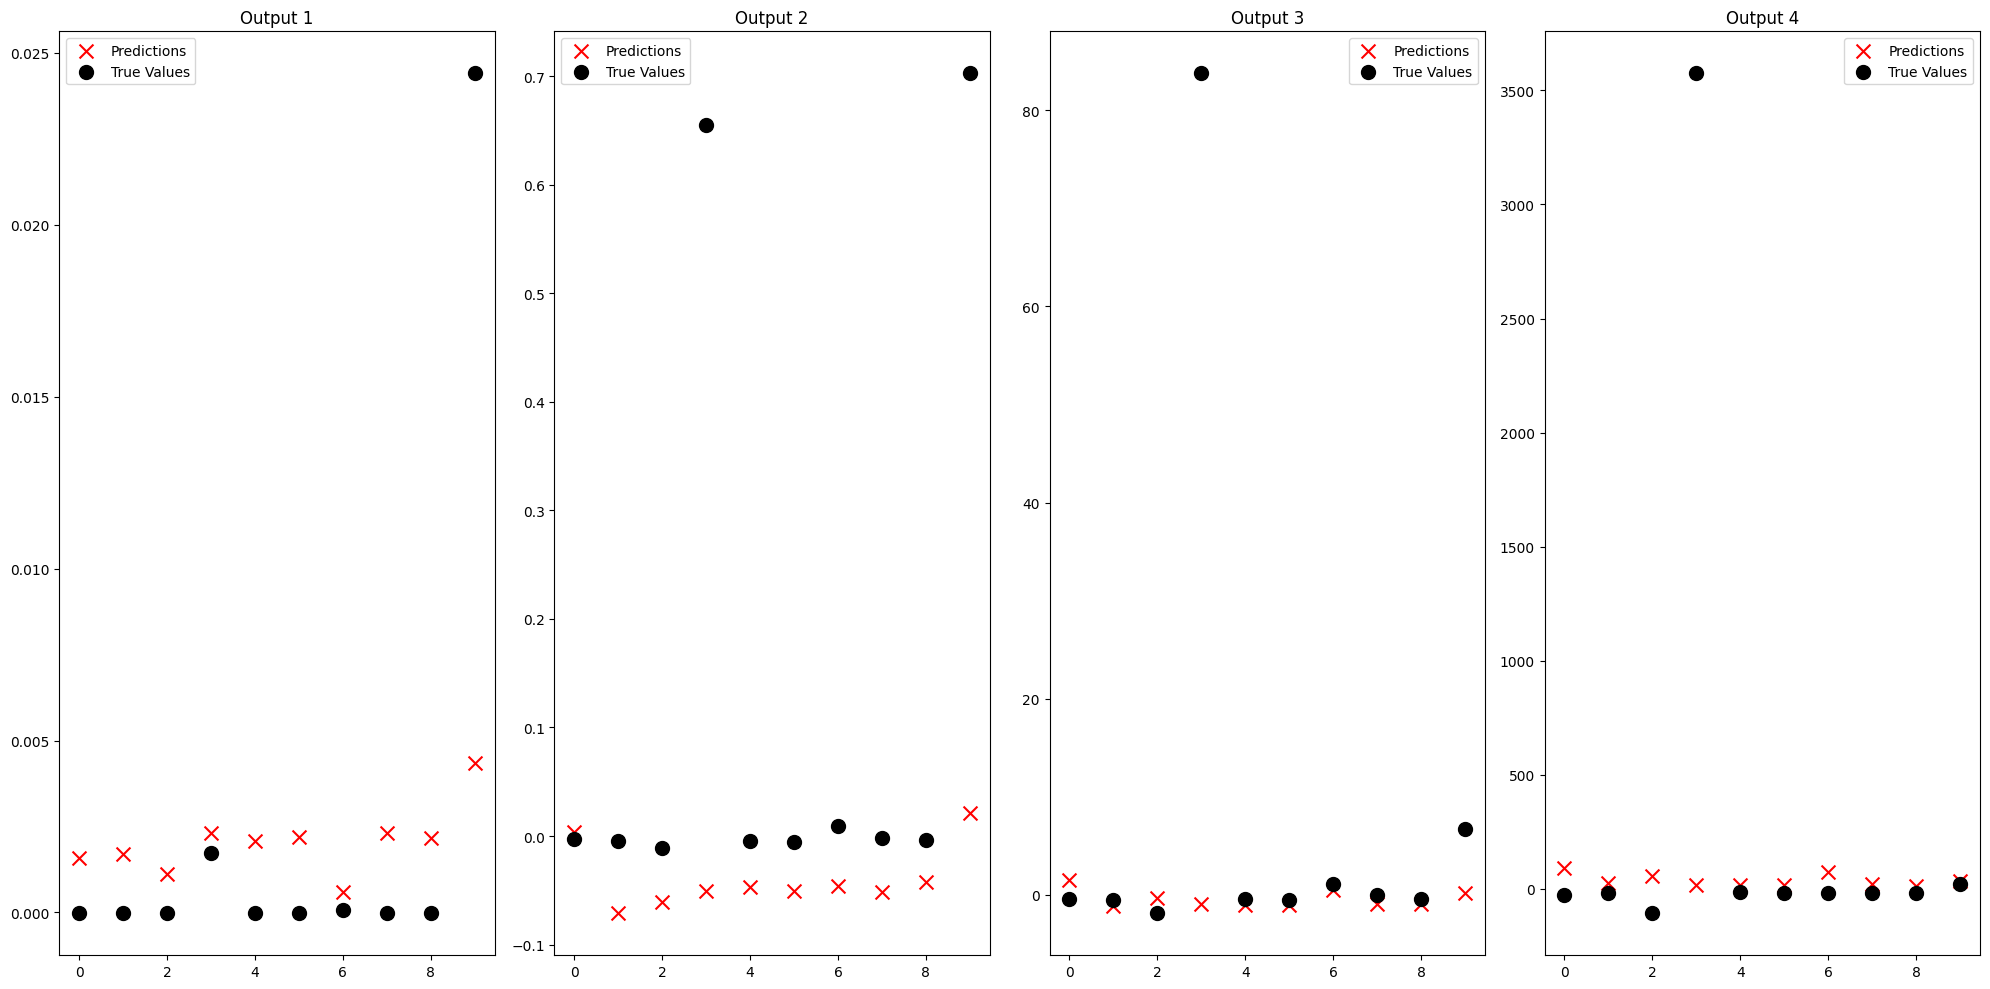

In [8]:
_, _, all_predictions, all_true_values = plot_inference_comparison(
    predictor2, n_samples=10, subplot_shape=(1, 4)
)

Cluster 3

86.4% of data retained after cleaning


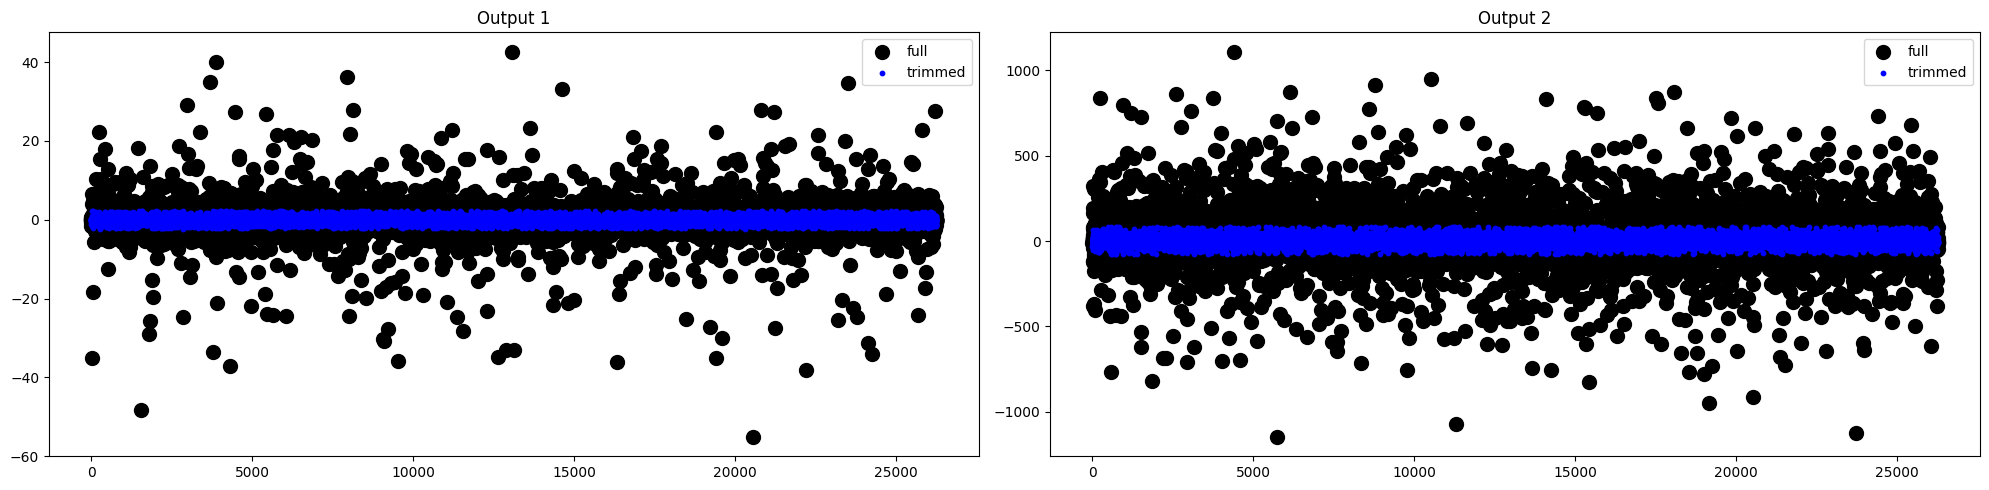

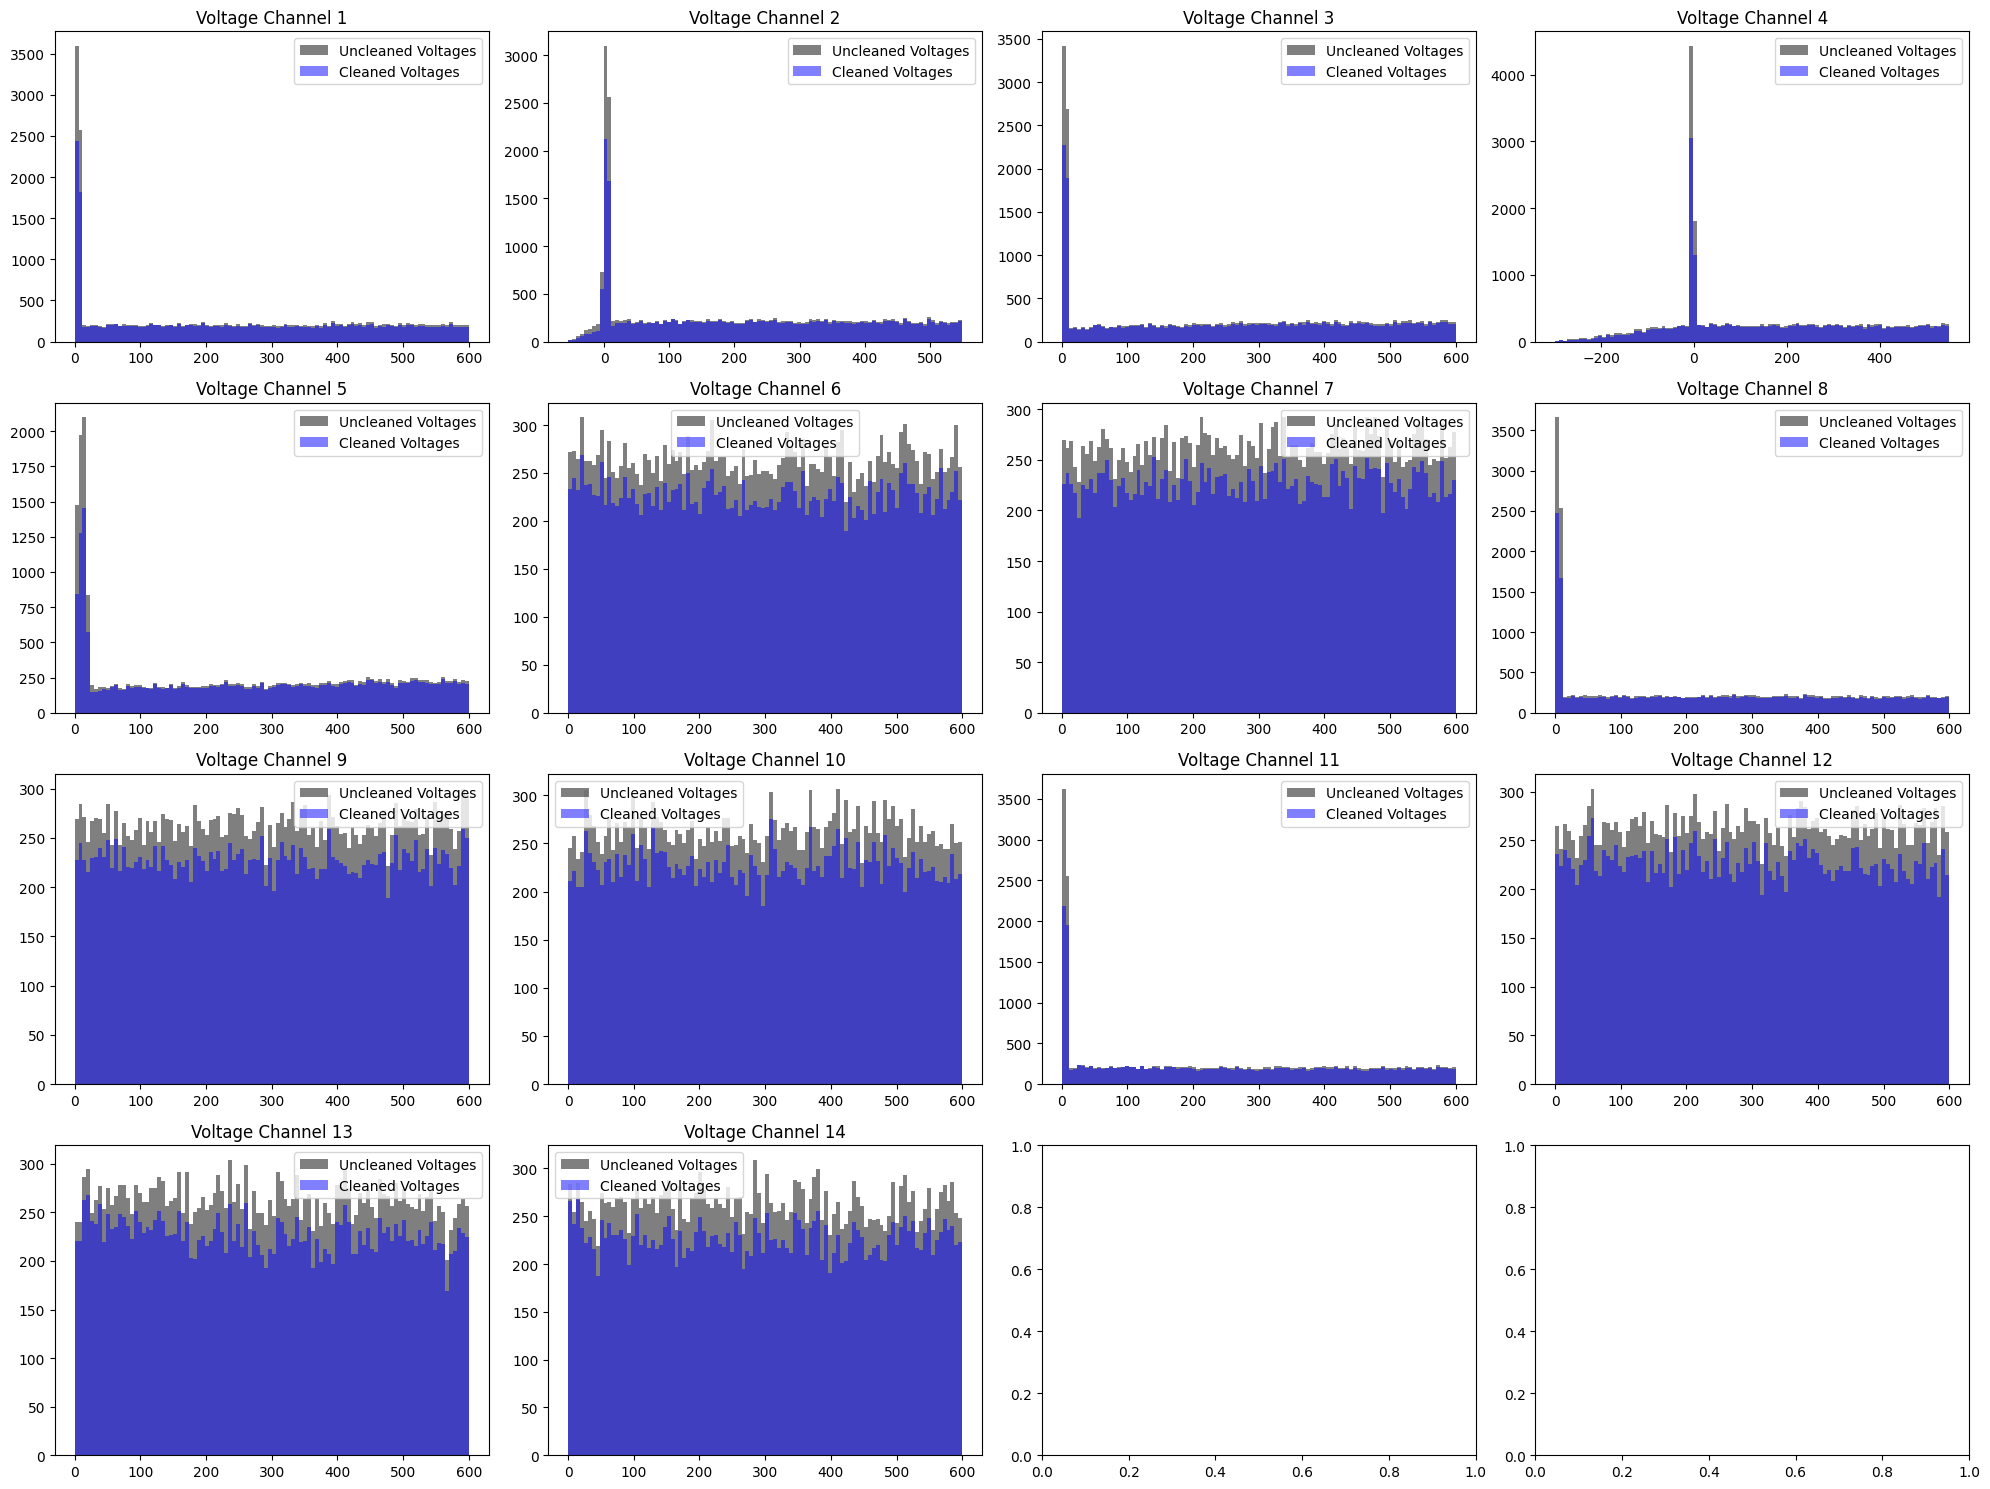

In [9]:
threshold = 1
_, ax, _, _, _, _ = trim_scatter(
    [
        "test_model_data.csv",
        "parallel_test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=20,
    output_values_end=21,
    trim_threshold=threshold,
    subplot_shape=(1, 2),
    figsize=(20, 5),
)
# ax[0].set_xlim(0, 100)


_, _, _, _, fig, ax = trim_hist(
    [
        "test_model_data.csv",
        "parallel_test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=20,
    output_values_end=21,
    trim_threshold=threshold,
    subplot_shape=(4, 4),
)

Using device: cpu
Training model...
Epoch 0: Train Loss = 0.423788, Val Loss = 0.149018
Training completed. Best validation loss: 0.001667


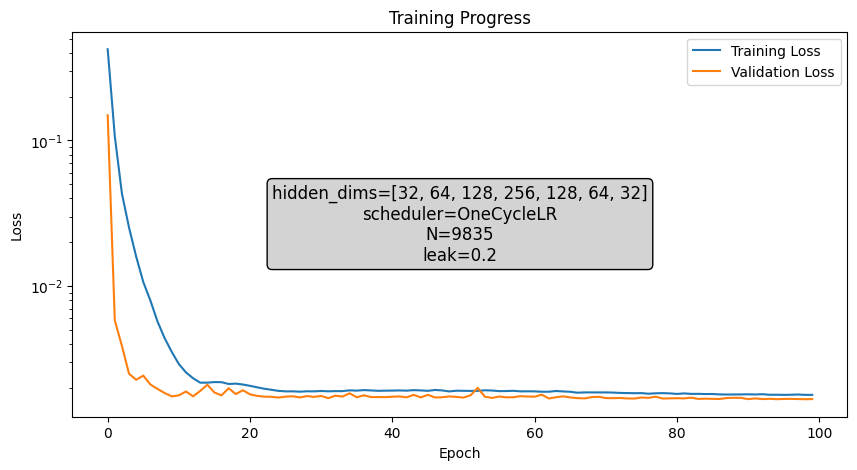

In [ ]:
n_voltages = 14  # Number of voltage parameters


n_output_values = 2  # Number of output values (e.g., magnification, aberration, etc.)


raw_voltages, raw_output_values = load_data(
    [
        "parallel_test_model_data.csv",
        "test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=20,
    output_values_end=21,
)
voltages, outputs, outlier_voltages, outlier_outputs = trim_outliers(
    raw_voltages,
    raw_output_values,
    trim_threshold=threshold,
    trim_mode=trim_mode,
)


# Create and train model


predictor3 = ElectronOpticsPredictor(
    input_dim=n_voltages, output_dim=n_output_values, leak=0.2
)


print("Training model...")



predictor3.train(
    outlier_voltages,
    outlier_outputs,
    epochs=100,
    verbose=True,
    weight_name="best_model3.pth",
)
predictor3.save_model("outlier_predictor3")

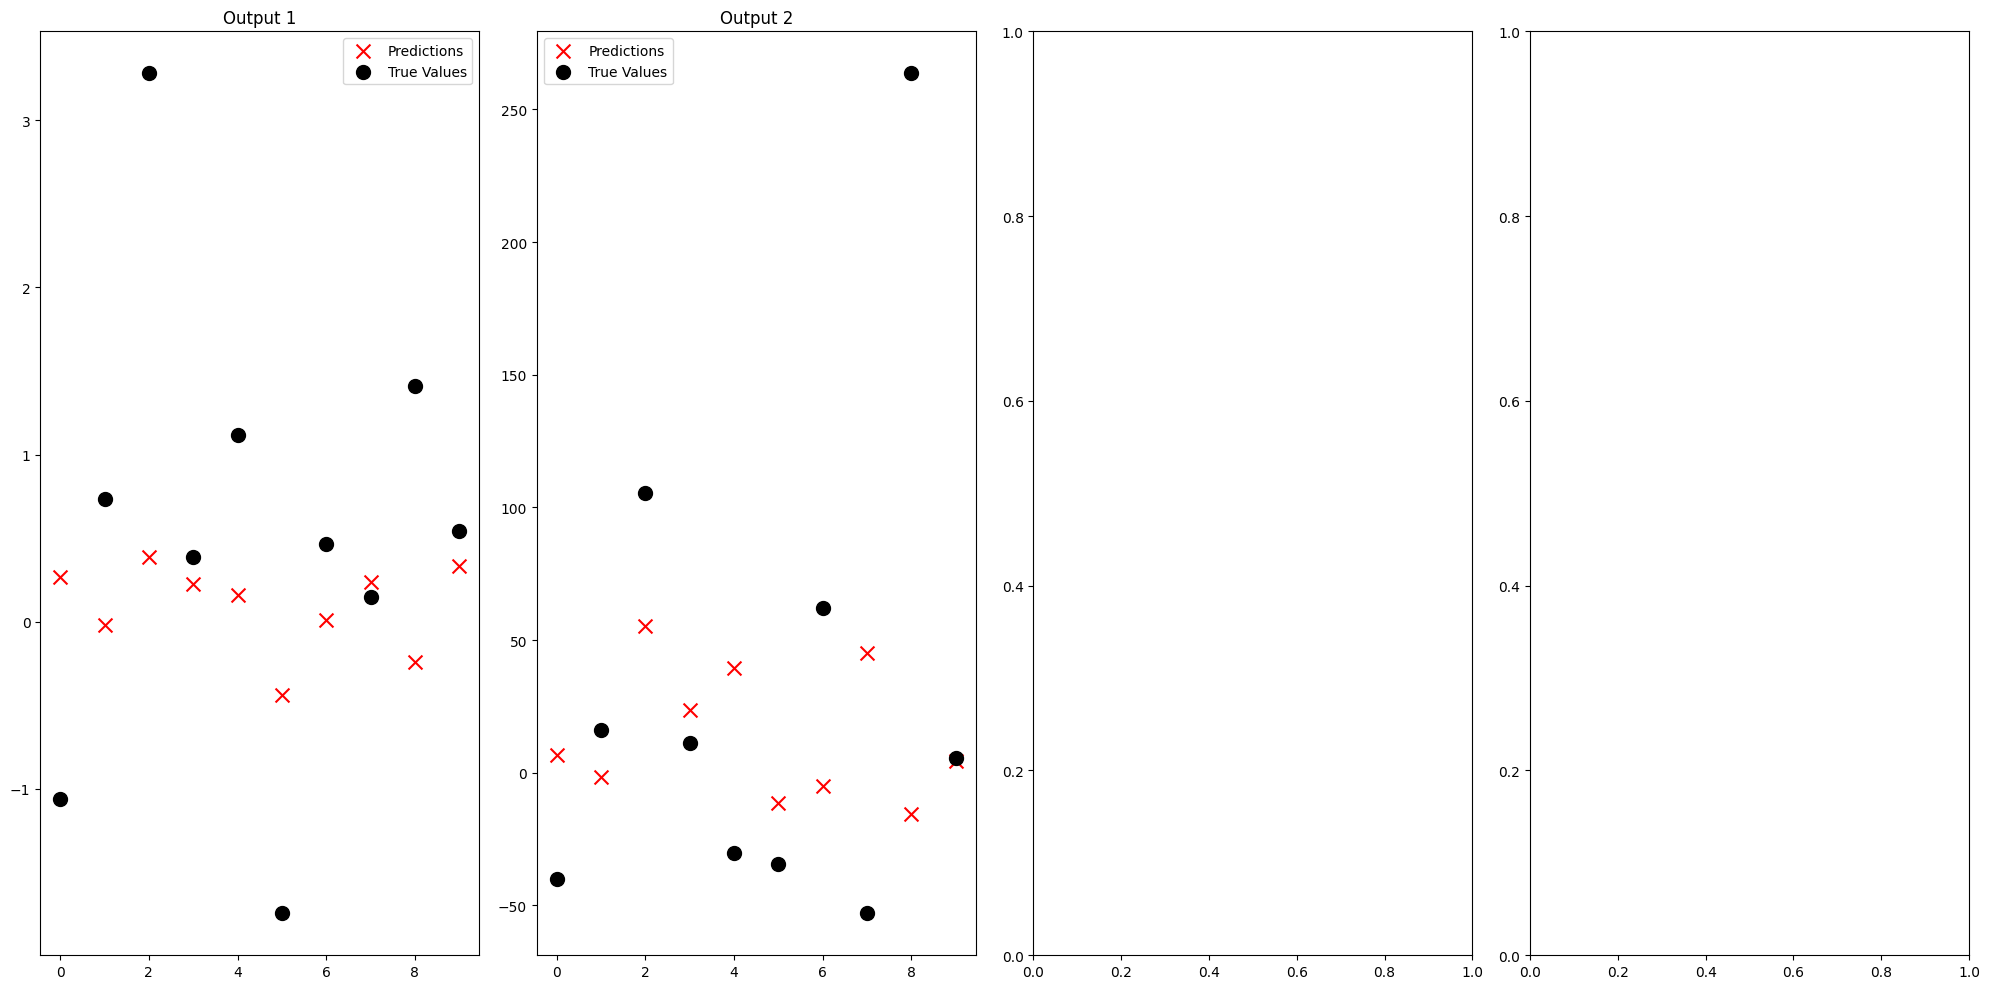

In [11]:
_, _, all_predictions, all_true_values = plot_inference_comparison(
    predictor3, n_samples=10, subplot_shape=(1, 4)
)

Cluster 4

77.3% of data retained after cleaning


(-0.2, 0.2)

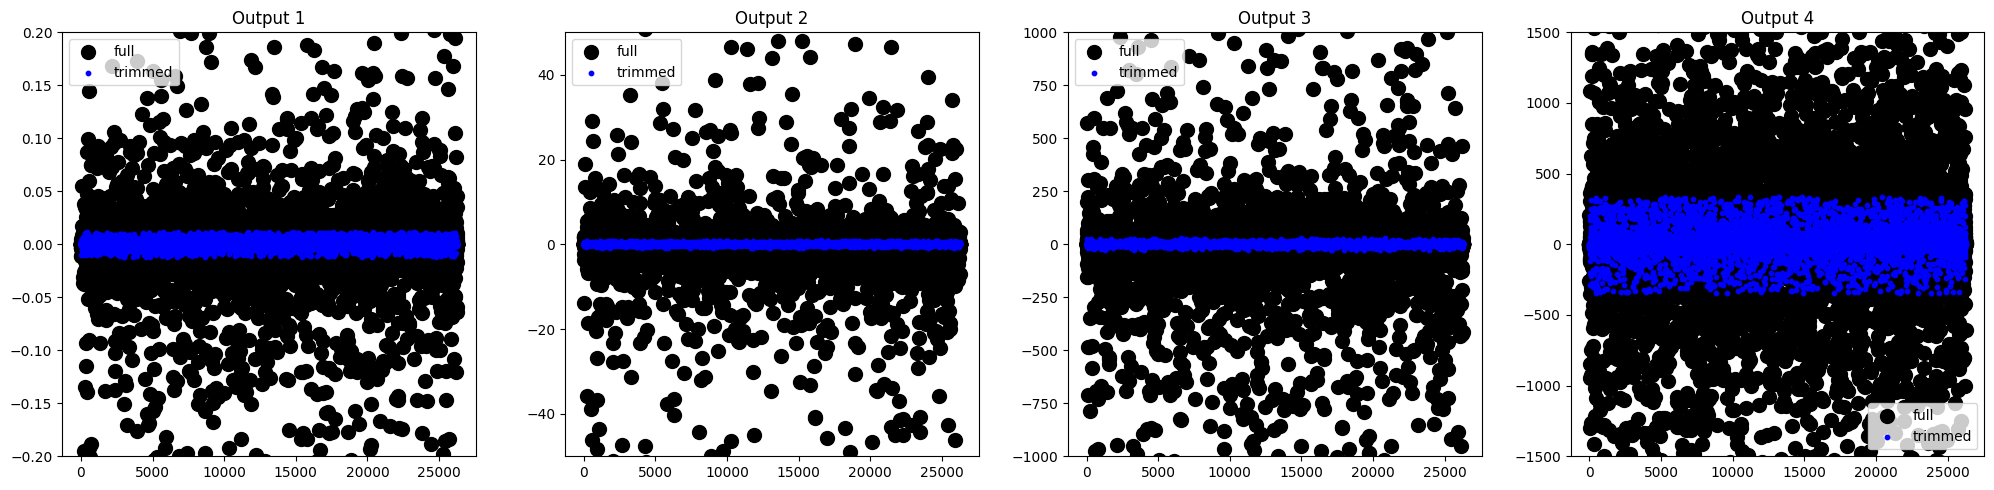

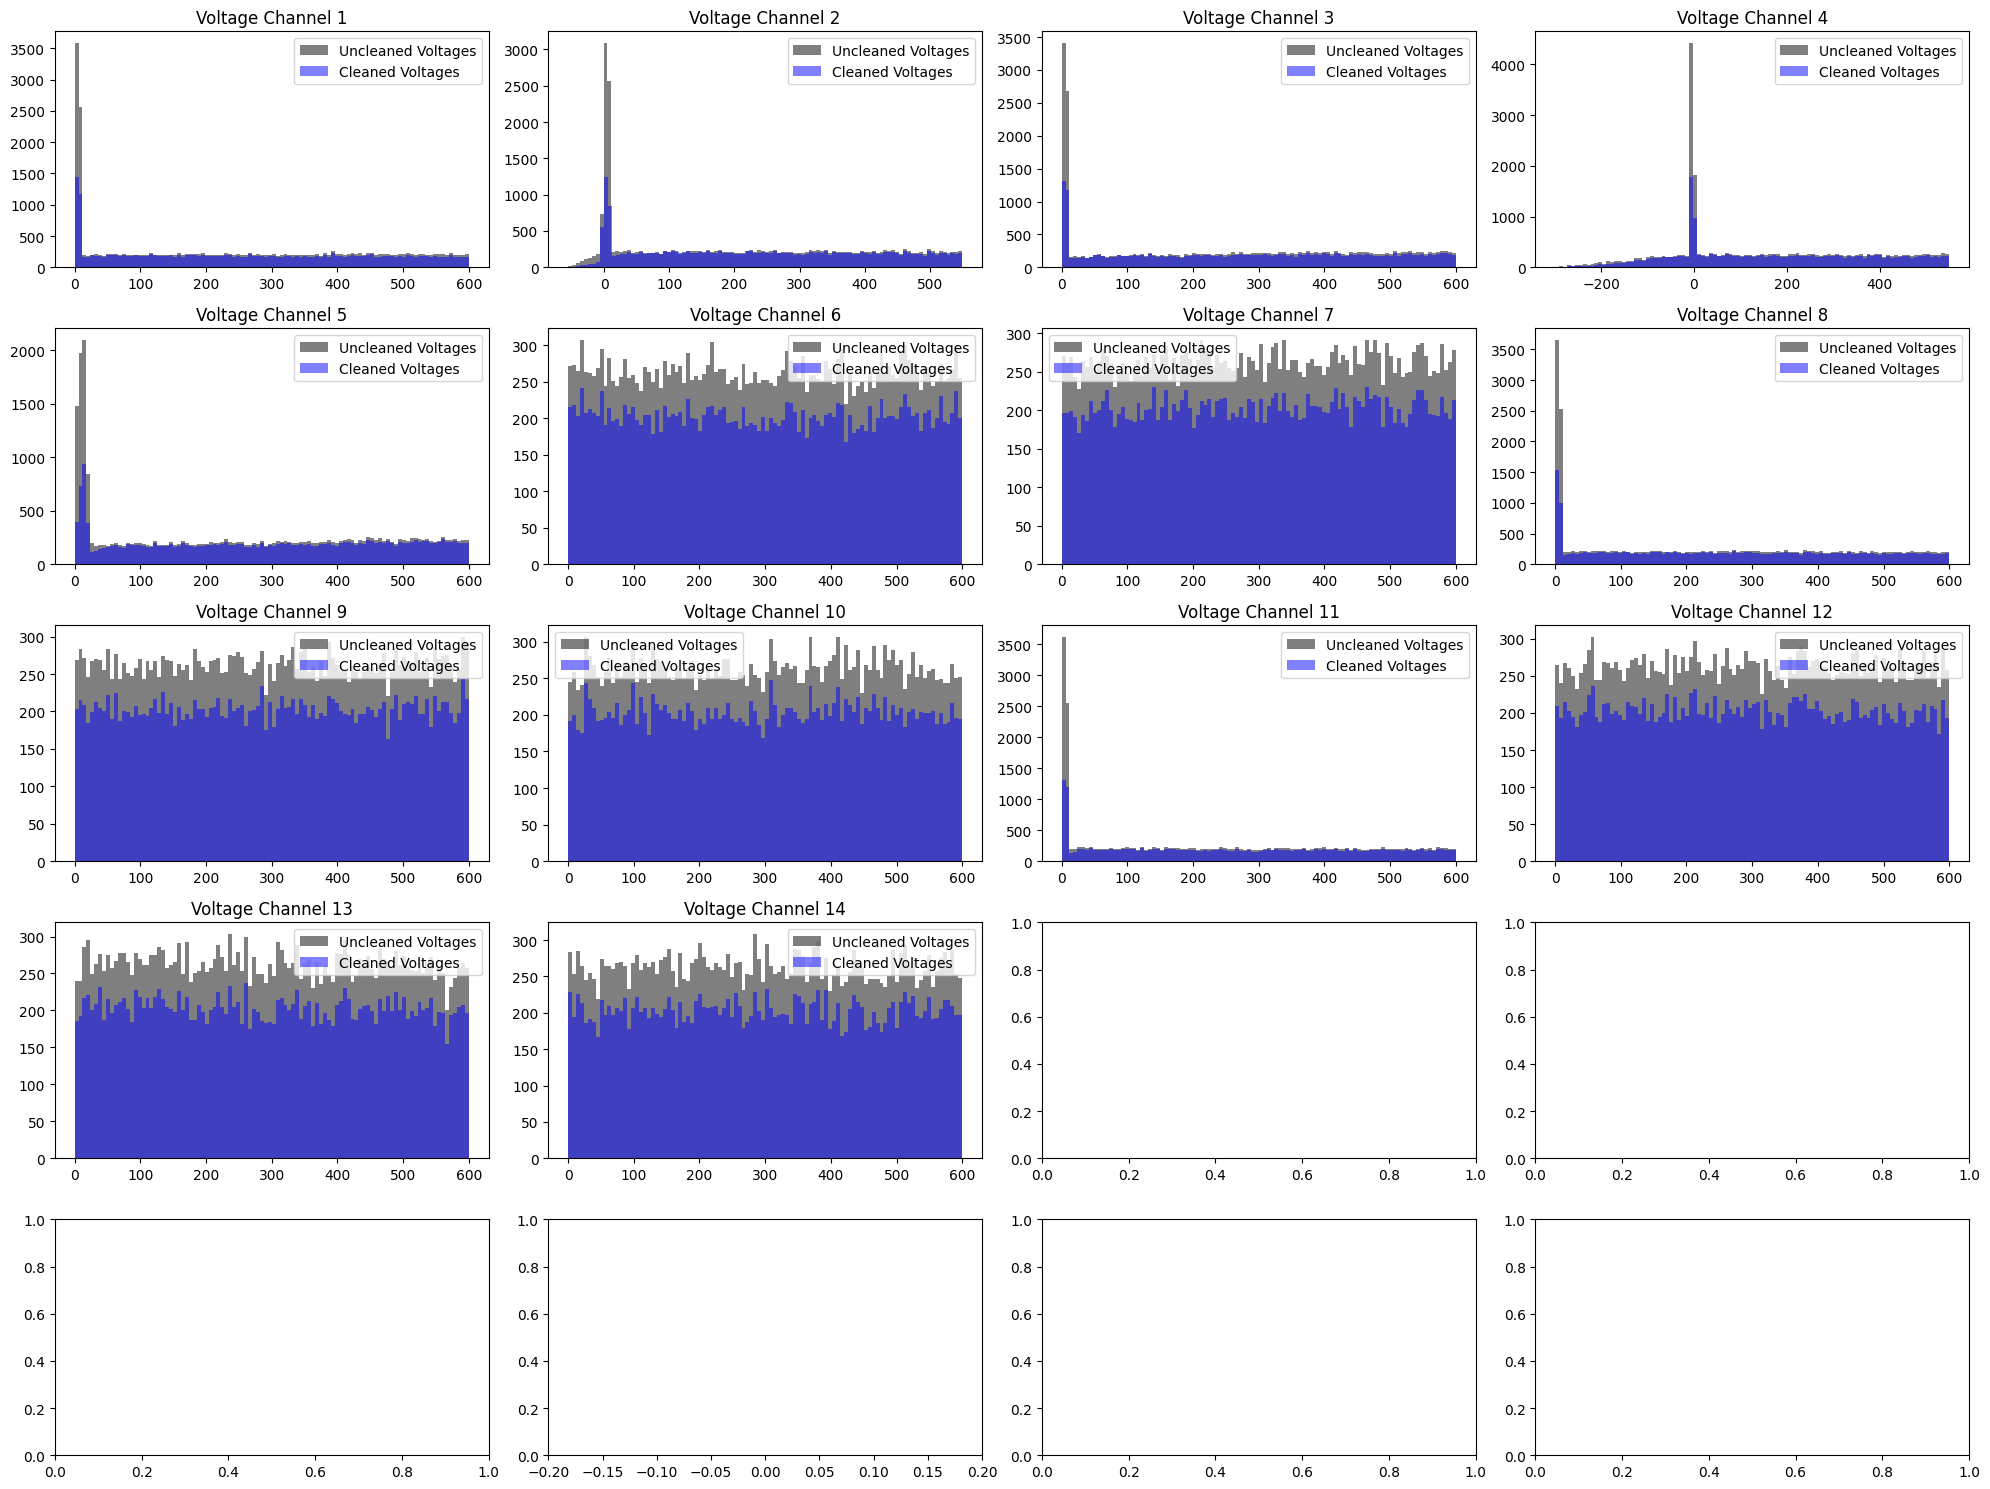

In [12]:
threshold = 20
_, ax, _, output_values, _, _ = trim_scatter(
    [
        "test_model_data.csv",
        "parallel_test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=22,
    output_values_end=25,
    trim_mode="iqr",
    trim_threshold=threshold,
    subplot_shape=(1, 4),
    figsize=(20, 5),
)
# ax[0].set_xlim(0, 100)
ax[0].set_ylim(-0.2, 0.2)
ax[1].set_ylim(-50, 50)
ax[2].set_ylim(-1000, 1000)
ax[3].set_ylim(-1500, 1500)


fig, ax, voltages_unclean, output_values_unclean, voltages, output_values = trim_hist(
    [
        "test_model_data.csv",
        "parallel_test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=22,
    output_values_end=25,
    trim_mode="iqr",
    trim_threshold=threshold,
    subplot_shape=(5, 4),
    hist_bins=100,
)

# ax[-1].scatter(np.arange(len(output_values)), output_values[:, 0])
ax[-3].set_xlim(-0.2, 0.2)

Using device: cpu
Training model...
Epoch 0: Train Loss = 0.264631, Val Loss = 0.020781
Training completed. Best validation loss: 0.000078


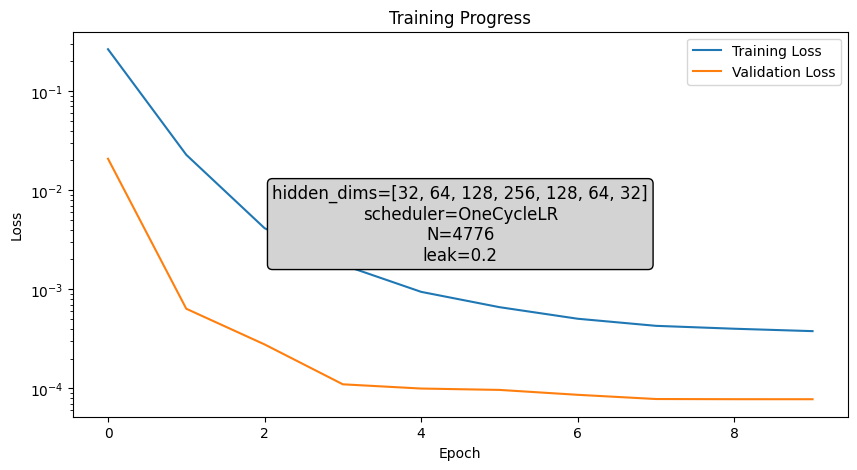

In [13]:
n_voltages = 14  # Number of voltage parameters
n_output_values = 4  # Number of output values (e.g., magnification, aberration, etc.)
raw_voltages, raw_output_values = load_data(
    [
        "parallel_test_model_data.csv",
        "test_model_data.csv",
        "outlier_target_model_data.csv",
    ],
    output_values_start=22,
    output_values_end=25,
)
voltages, outputs, outlier_voltages, outlier_outputs = trim_outliers(
    raw_voltages,
    raw_output_values,
    trim_threshold=threshold,
    trim_mode=trim_mode,
)
# Create and train model
predictor4 = ElectronOpticsPredictor(
    input_dim=n_voltages, output_dim=n_output_values, leak=0.2
)
print("Training model...")
predictor4.train(
    outlier_voltages,
    outlier_outputs,
    epochs=10,
    verbose=True,
    weight_name="best_model4.pth",
)
predictor4.save_model("outlier_predictor4")

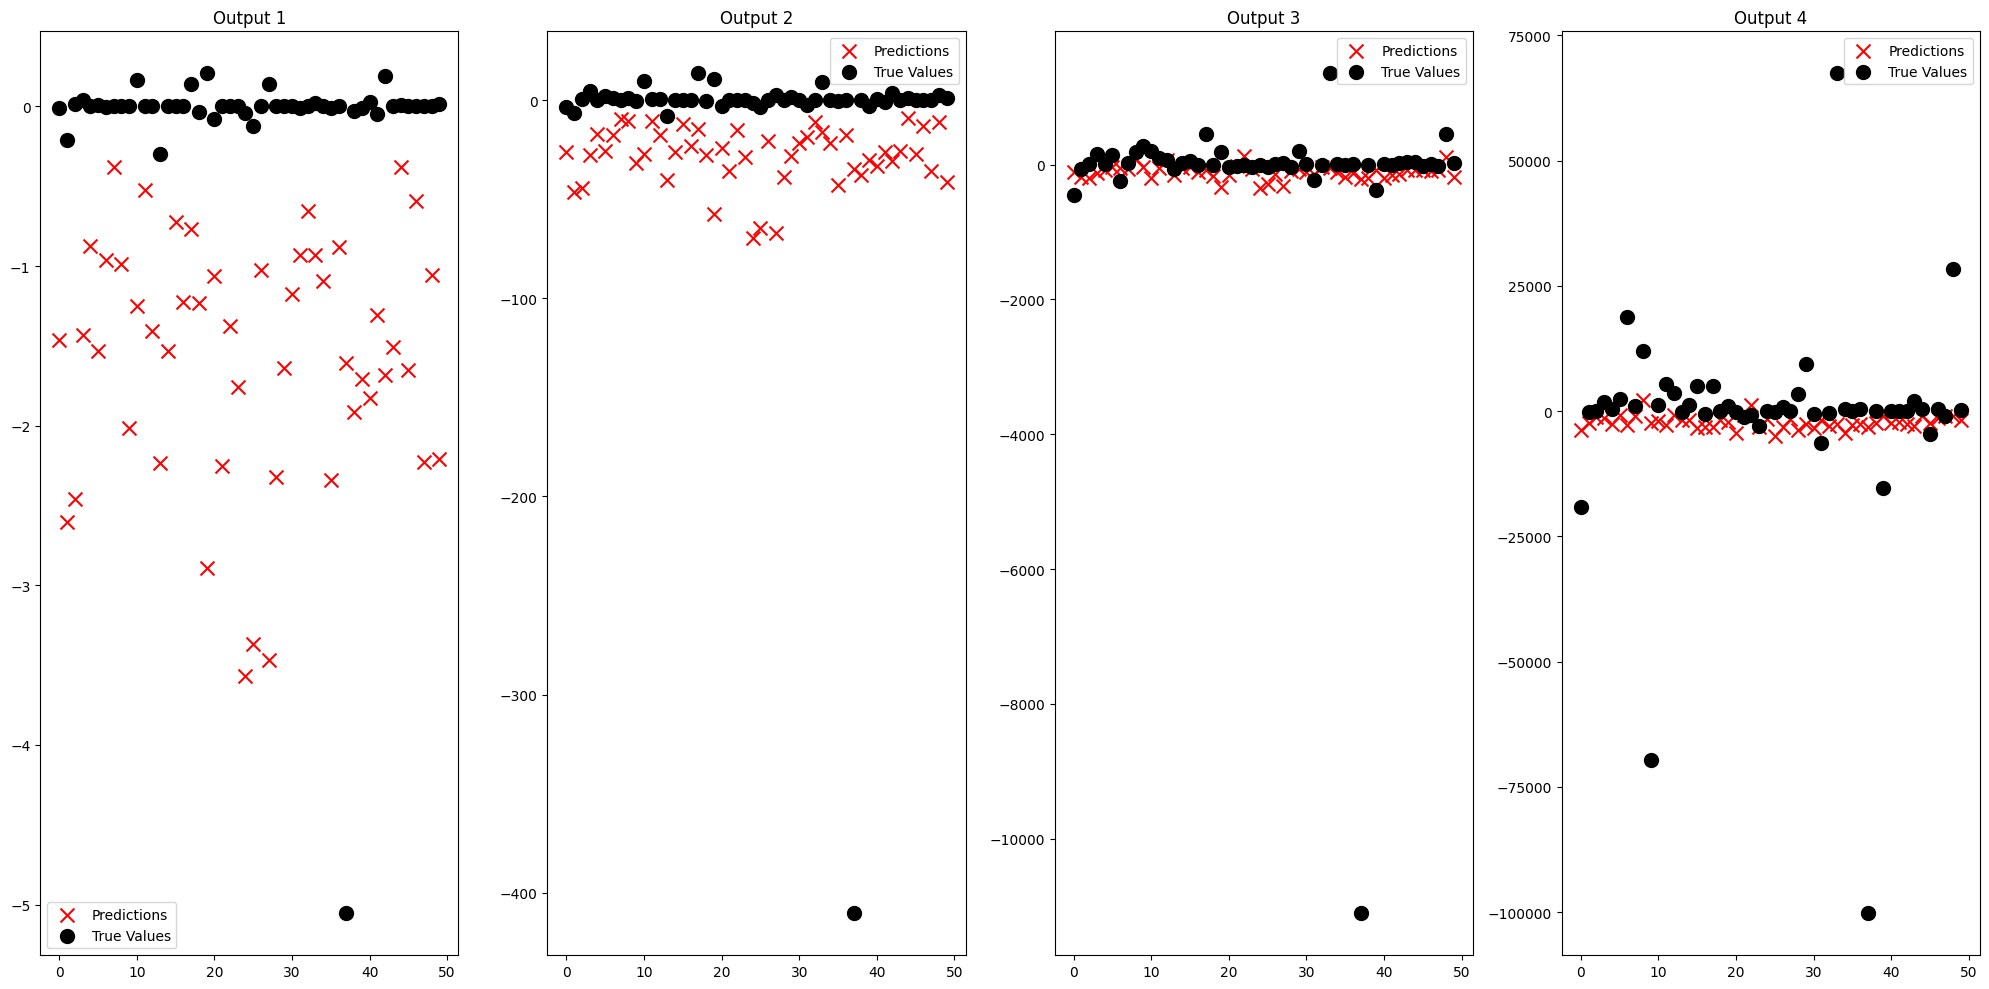

In [14]:
_, _, all_predictions, all_true_values = plot_inference_comparison(
    predictor4,
    n_samples=50,
    subplot_shape=(1, 4),
)

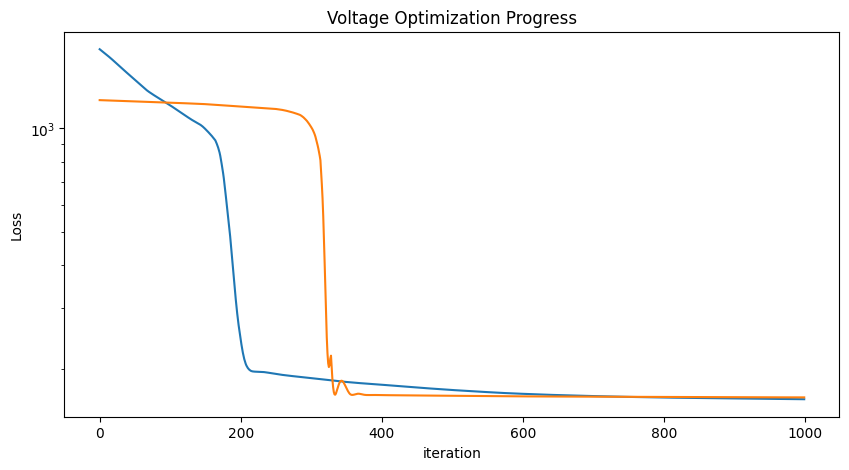

In [17]:
best_voltages, best_values, best_objective = optimize_voltages(
    [predictor1, predictor2, predictor3, predictor4], metric, random_restarts=2
)


# best voltages for good metric, output values of the best voltages, and the metric value

In [18]:
best_voltages, best_objective

(array([288.1487  , 240.71347 , 100.424706, 173.71002 , 369.2142  ,
         67.130615, 102.66386 , 531.54315 , 328.88358 , 225.59892 ,
        460.71744 , 540.118   , 428.09558 , 240.6775  ], dtype=float32),
 164.8029327392578)